In [1]:
#import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
from matplotlib.pyplot import figure
from ete3 import Tree
import os 
import ete3
from scipy.optimize import curve_fit
import scipy 
import numpy.ma as ma
from sklearn.metrics import r2_score
import bisect
import ast
#r2 = r2_score(gt_height, inferred_heights)
def func(x, a):
    return a * x
def func_i(x, a, b):
    return a * x + b
path = 'simulated/v8_ginkgo'
with open(path + '/gt.nw', 'r') as tree_file:
        gt_tree = tree_file.read().replace('\n', ';')
        #print(gt_tree)
        gt_tree = Tree(gt_tree, format = 3)

In [2]:
def read_trees(file):
    tree_collection = []
    for newick in open(file):
        tree_collection.append(Tree(newick))
    return tree_collection

def root_by_diploid(trees):
    tree_collection = []
    for tree in trees:
        tree.set_outgroup( "diploid" )
        for node in tree.traverse():
            if node.name == 'diploid':
                node.detach()
        tree_collection.append(tree)
    return tree_collection

def get_partition(tree, minimal_value):
    partition = []
    partition_edge = []
    for node in tree.traverse():
        L = []
        if node.is_root():
            pass
        elif node.up.is_root():
            pass
        elif node.is_leaf():
            pass
        else:
            if node.dist > minimal_value and node.dist != 0.0228035:
                #print(node.name)
                for leaf in node:
                    L.append(leaf.name)
                partition.append(sorted(L))
                partition_edge.append(node.dist)
    #print(partition_edge)
    return partition, partition_edge

def get_tp_rate(gt_tree, min_branch, tree_list):
    gt_partition, corres_edge = get_partition(gt_tree, 0)
    clade_count = [0]* len(gt_partition)
    for tree in tree_list: 
        partition = get_partition(tree, 0)[0]
        for i in range(0, len(gt_partition)):
            if all(elem in partition for elem in [gt_partition[i]]):
                #print('in')
                clade_count[i] = clade_count[i] + 1
    #print([n/len(tree_list) for n in clade_count])
    return clade_count, corres_edge, len(tree_list)

def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

def bin_map(edges, rate):
    d = dict(zip(edges, rate))
    quantiles = []
    for num in np.linspace(0,1,11):
        quantiles.append(np.quantile(sorted(edges), num))
    keyList = np.arange(0,10)
    r_lbd = {key: [] for key in keyList}
    for edge in edges:
        qs = bisect.bisect_left(quantiles, edge)
        #print(qs)
        if qs == 0:
            pass
        else: 
            qs = qs -1
        r_lbd[qs].append(d[edge])
    result = []
    for key in r_lbd.keys():
        result.append(np.mean(r_lbd[key]))
    return sorted(result)

In [3]:
gt_partition, corres_edge= get_partition(gt_tree, 0)
clade_count = [0]* len(gt_partition)
bds_all = [0]*len(gt_partition)
mp_all = [0]*len(gt_partition)
nj_all = [0]*len(gt_partition)
bds_total = 0
mp_total = 0
nj_total = 0
for rep in ['rep0','rep1','rep2','rep3','rep4','rep5', 'rep6','rep7','rep8','rep9']:
    path = 'simulated/v8_gt/real_' + rep
    bds = read_trees(path + '/boostrap/BDS.nw')
    mp = read_trees(path + '/boostrap/MP_boostrap.nw')
    mp = root_by_diploid(mp)
    nj = read_trees(path + '/boostrap/NJ_boostrap.nw')
    nj = root_by_diploid(nj)
    bds_tp = get_tp_rate(gt_tree, 0, bds)
    mp_tp = get_tp_rate_(gt_tree, 0, mp)
    nj_tp = get_tp_rate_(gt_tree, 0, nj)
    bds_all = [a + b for a, b in zip(bds_all, bds_tp[0])]
    mp_all = [a + b for a, b in zip(mp_all, mp_tp[0])]
    nj_all = [a + b for a, b in zip(nj_all, nj_tp[0])]
    bds_total = bds_total + bds_tp[2]
    mp_total = mp_total + mp_tp[2]
    nj_total = nj_total + nj_tp[2]

In [4]:
corres_edge = np.array(corres_edge)
bds_all_d = [number / bds_total for number in bds_all]
mp_all_d = [number / mp_total for number in mp_all]
nj_all_d = [number / nj_total for number in nj_all]

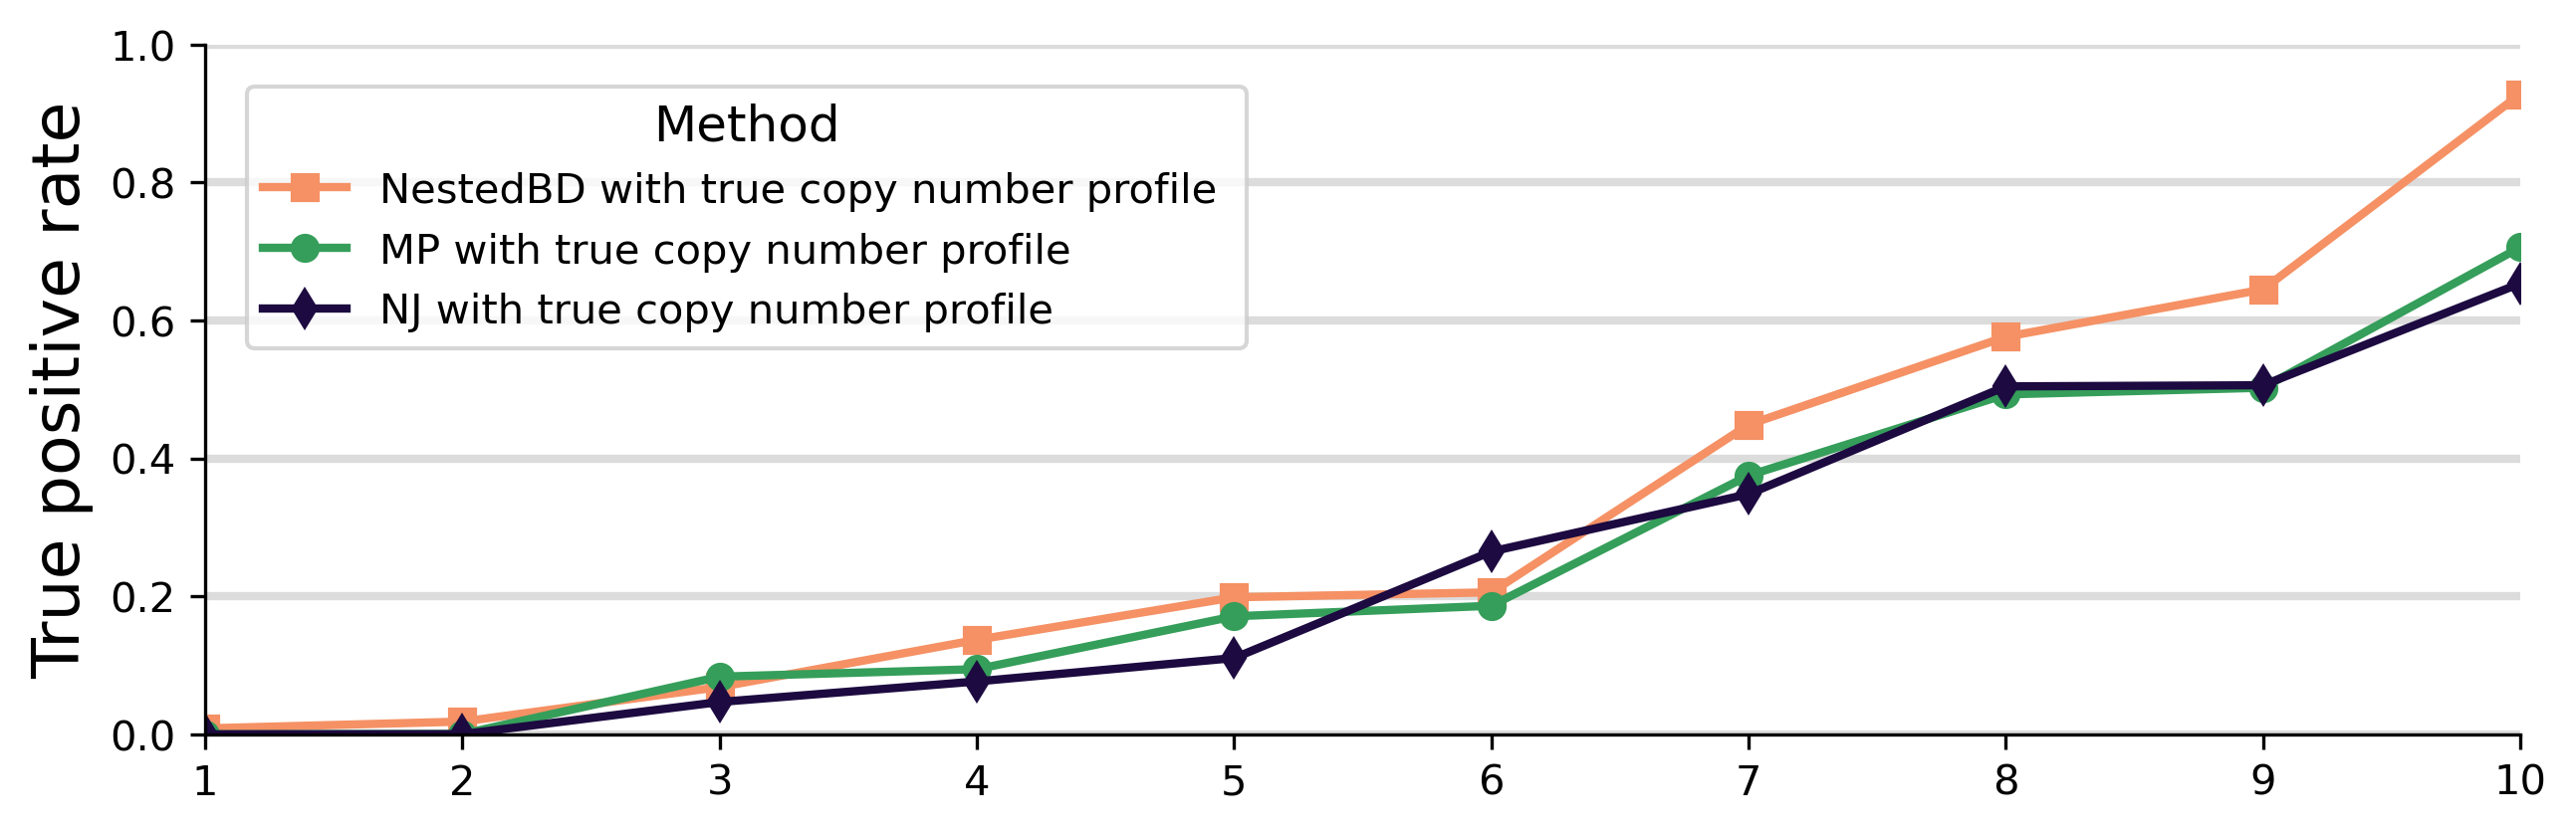

In [6]:
from matplotlib.pyplot import figure
import matplotlib
matplotlib.rc_file_defaults()
figure(figsize=(10,3), dpi=300)
ax = plt.subplot(111)
binned_bd = bin_map(corres_edge, bds_all_d)
binned_mp = bin_map(corres_edge_, mp_all_d)
binned_nj =  bin_map(corres_edge_, nj_all_d)
data = [binned_bd, binned_mp, binned_nj]
labels = ['NestedBD with true copy number profile ', 'MP with true copy number profile', 'NJ with true copy number profile']
markers = ['s','o','d']
colors = ['#f59164','#359E5A','#1c0a40']
for i in range(0, 3):
    plt.plot(np.arange(1,11),data[i], label = labels[i], marker=markers[i], color = colors[i],linewidth=2)
plt.ylim(0, 1.0)
plt.xlim(1,10)
#ax.set_facecolor('gainsboro')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
plt.ylabel('True positive rate', fontsize = 16)
#plt.xlabel('Branch Length Decile', fontsize = 16)
plt.legend(loc='upper left', borderaxespad=1 ,title="Method",fontsize='10', title_fontsize = '12')
#ax.text(0.5,-0.2, 'Short', fontsize = 12)
#ax.text(9.8,-0.2, 'Long', fontsize = 12)
plt.grid(color = 'gainsboro', linewidth = 2,axis='y')
plt.show()